In [1]:
from typing import Optional

import numpy as np
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.stats import chi2, norm, gumbel_r

from statsmodels.graphics.gofplots import qqplot
from pathlib import Path

from lrv_test import LRV, LRVResult
from lrv_test.types import real_function
from statsmodels.graphics.gofplots import qqplot

from scipy.stats import norm

from data_generation.arma import generate_arma_sample
from data_generation.spectral_density import arma_spectral_density

import seaborn as sns

sns.set_style("whitegrid")

# Limit distribution check

In [2]:
def run(
    f: real_function,
    N: int,
    M: int,
    B: int,
    ar: float,
    ma: float,
    freqs: np.ndarray,
    oracle_sd: Optional[real_function] = None,
    L: Optional[int] = None,
) -> LRVResult:
    y = generate_arma_sample(N, M, ar, ma)
    return LRV(y, B, f, freqs=freqs, L=L, sd=oracle_sd)

In [3]:
# Define once properties of the arma process to generate
N, B, M = 10_000, 301, 120
ar, ma = 0.1, 0.5

# Define the function / frequencies to test
f = lambda x: (x - 1) ** 2
freqs = np.arange(-0.4, 0.6, B / N)

# Define the number of repetitions
n_repeat = 10**4

# storage path
storage_path = Path("./plots/clt_arma")
storage_path.mkdir(parents=True, exist_ok=True)

In [4]:
# Use LRV when spectral density is known
oracle_sd = arma_spectral_density(ar, ma)
L = None

results_oracle = Parallel(n_jobs=5)(
    delayed(run)(f, N, M, B, ar, ma, freqs, oracle_sd, L)
    for _ in tqdm(range(n_repeat), total=n_repeat)
)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [24:05<00:00,  6.92it/s]


In [5]:
L = 6
oracle_sd = None

results_hat = Parallel(n_jobs=5)(
    delayed(run)(f, N, M, B, ar, ma, freqs, oracle_sd, L)
    for _ in tqdm(range(n_repeat), total=n_repeat)
)

100%|██████████| 10000/10000 [1:55:44<00:00,  1.44it/s]    


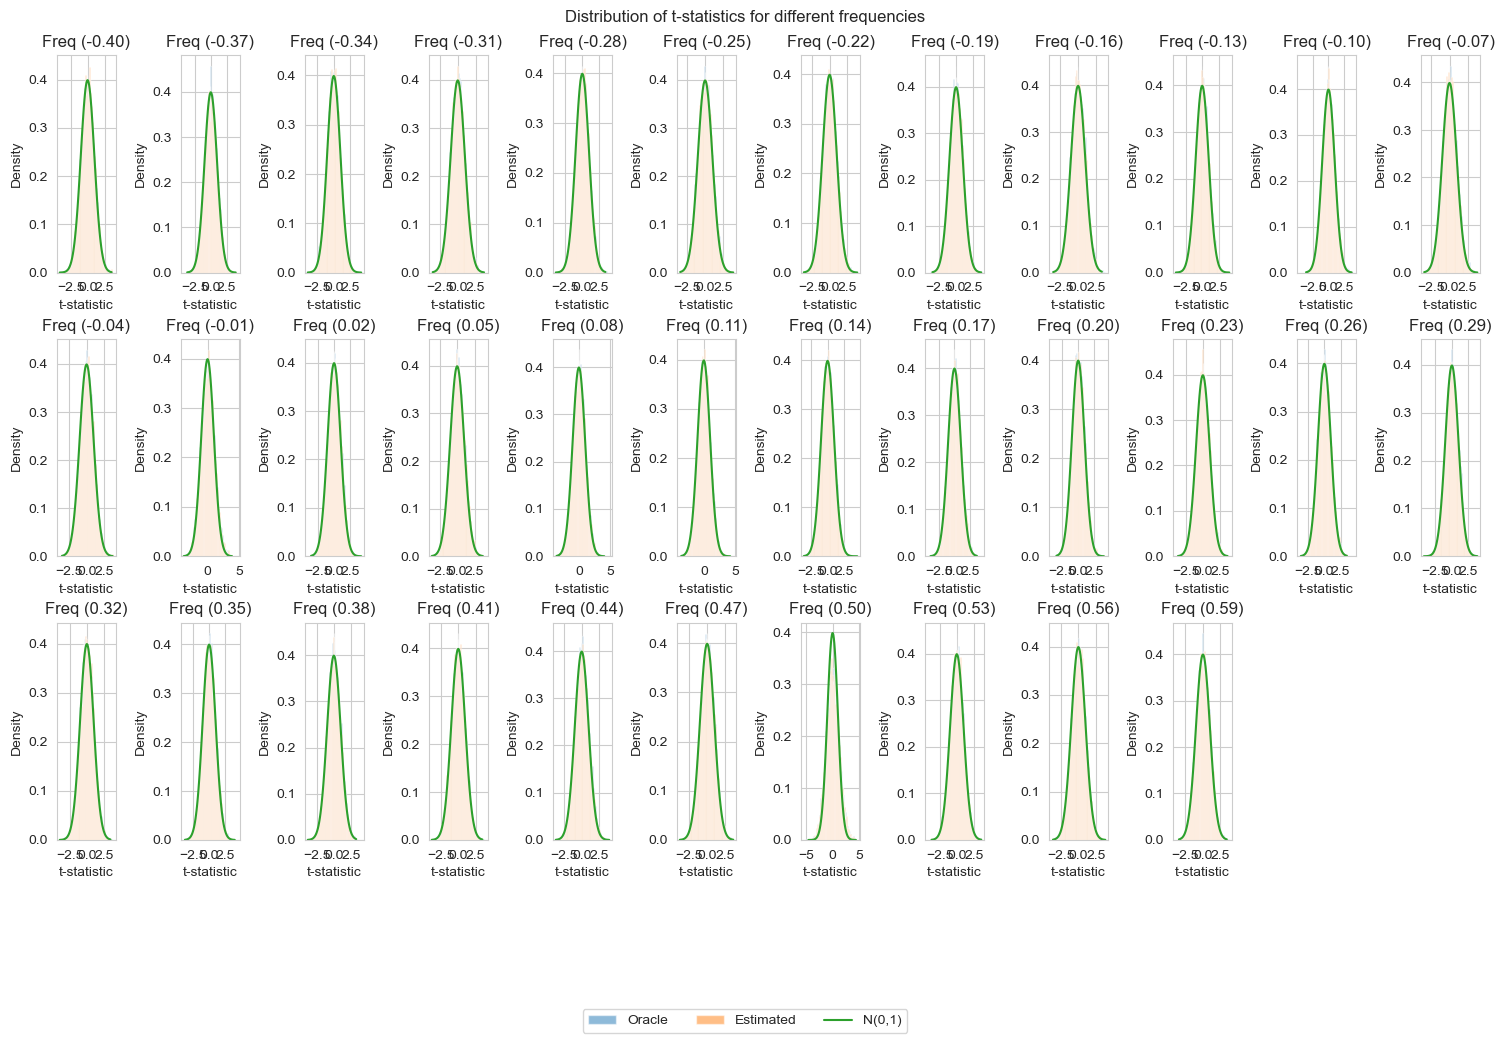

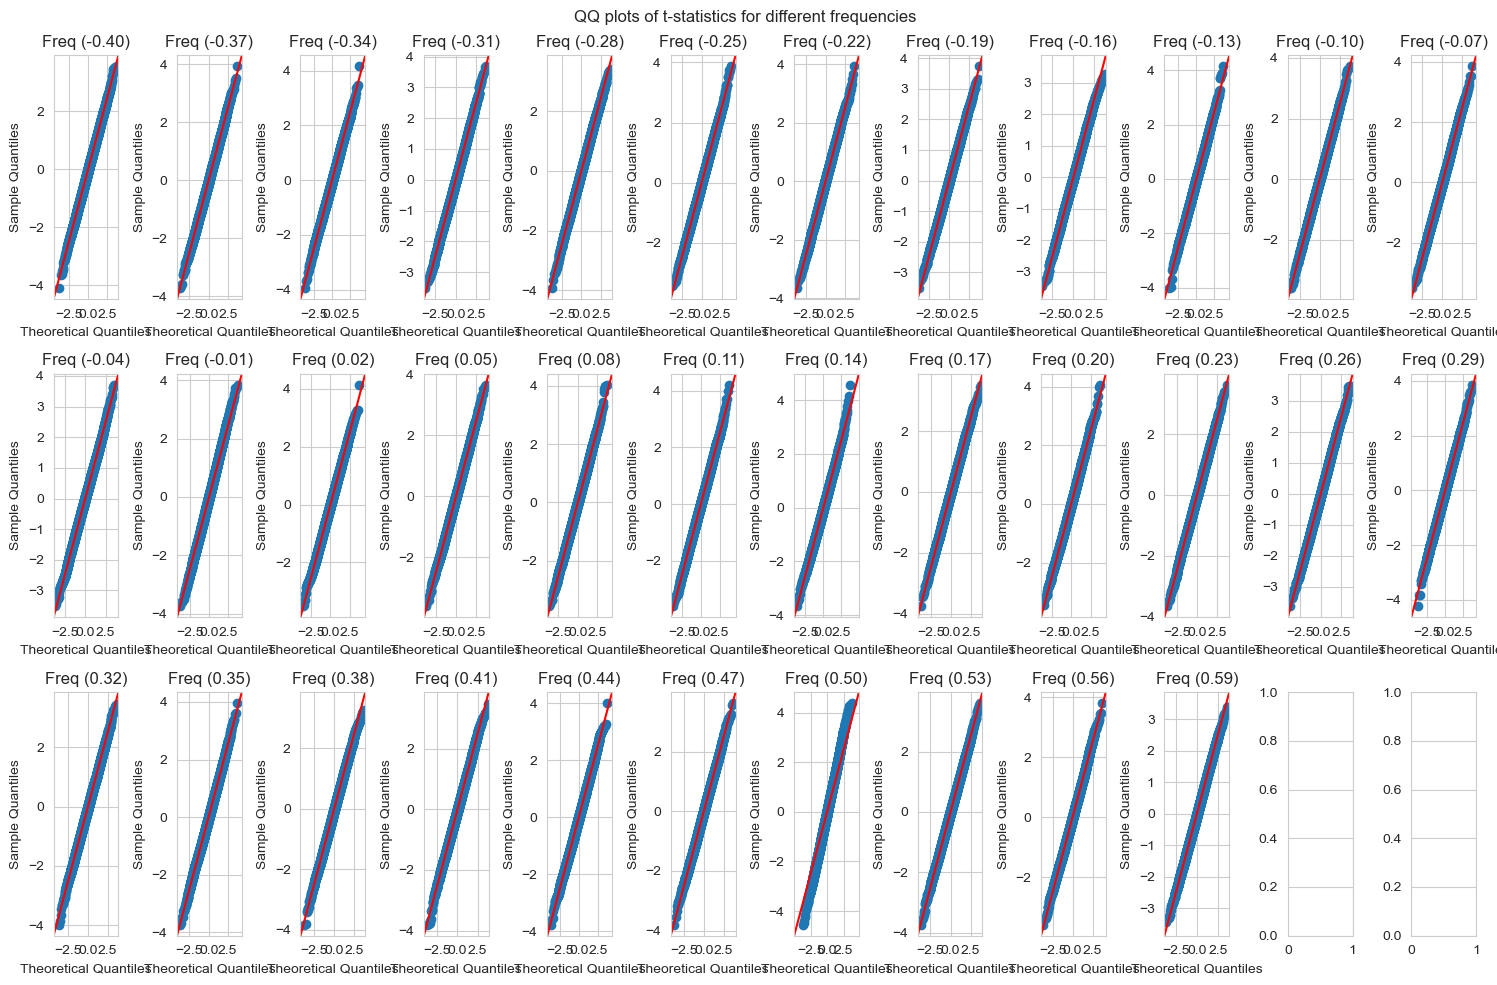

In [6]:
# plot distribution of t_stat_0
n_freqs = len(results_oracle[0].t_stats_0)
fig, axs = plt.subplots(3, n_freqs // 3 + 1, figsize=(15, 10))
axs = axs.flatten()

# Create empty lists to store plot objects for the legend
oracle_plots = []
estimated_plots = []
normal_plots = []

for i in range(n_freqs):
    ax = axs[i]
    all_t_stat_0_oracle = np.array([r.t_stats_0[i] for r in results_oracle])
    all_t_stat_0_hat = np.array([r.t_stats_0[i] for r in results_hat])

    # Plot histograms
    oracle_plot = ax.hist(
        all_t_stat_0_oracle, bins=100, density=True, alpha=0.5, label="Oracle"
    )
    estimated_plot = ax.hist(
        all_t_stat_0_hat, bins=100, density=True, alpha=0.5, label="Estimated"
    )

    # Plot N(0,1) distribution
    x_range = np.linspace(np.min(all_t_stat_0_hat), np.max(all_t_stat_0_hat), 100)
    normal_plot = ax.plot(x_range, norm.pdf(x_range, 0, 1), label="N(0,1)")

    ax.set_title(f"Freq ({freqs[i]:.2f})")
    ax.set_xlabel("t-statistic")
    ax.set_ylabel("Density")

    # Store plot objects for the legend
    oracle_plots.append(oracle_plot[2][0])
    estimated_plots.append(estimated_plot[2][0])
    normal_plots.append(normal_plot[0])

# Remove empty subplots
for i in range(n_freqs, len(axs)):
    fig.delaxes(axs[i])

fig.suptitle("Distribution of t-statistics for different frequencies")

plt.tight_layout()

# Add a single legend to the figure
fig.legend(
    [oracle_plots[0], estimated_plots[0], normal_plots[0]],
    ["Oracle", "Estimated", "N(0,1)"],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
)

# Adjust the layout to make room for the legend
plt.subplots_adjust(bottom=0.15)
plt.show()

fig, axs = plt.subplots(3, n_freqs // 3 + 1, figsize=(15, 10))
axs = axs.flatten()

for ax, i in zip(axs, range(n_freqs)):
    ax.set_title(f"Freq ({freqs[i]:.2f})")
    all_t_stat_0_oracle = np.array([r.t_stats_0[i] for r in results_oracle])
    all_t_stat_0_hat = np.array([r.t_stats_0[i] for r in results_hat])
    qqplot(all_t_stat_0_hat, dist=norm, line="45", ax=ax)

# add a global title
fig.suptitle("QQ plots of t-statistics for different frequencies")

# tight layout
plt.tight_layout()
plt.show()

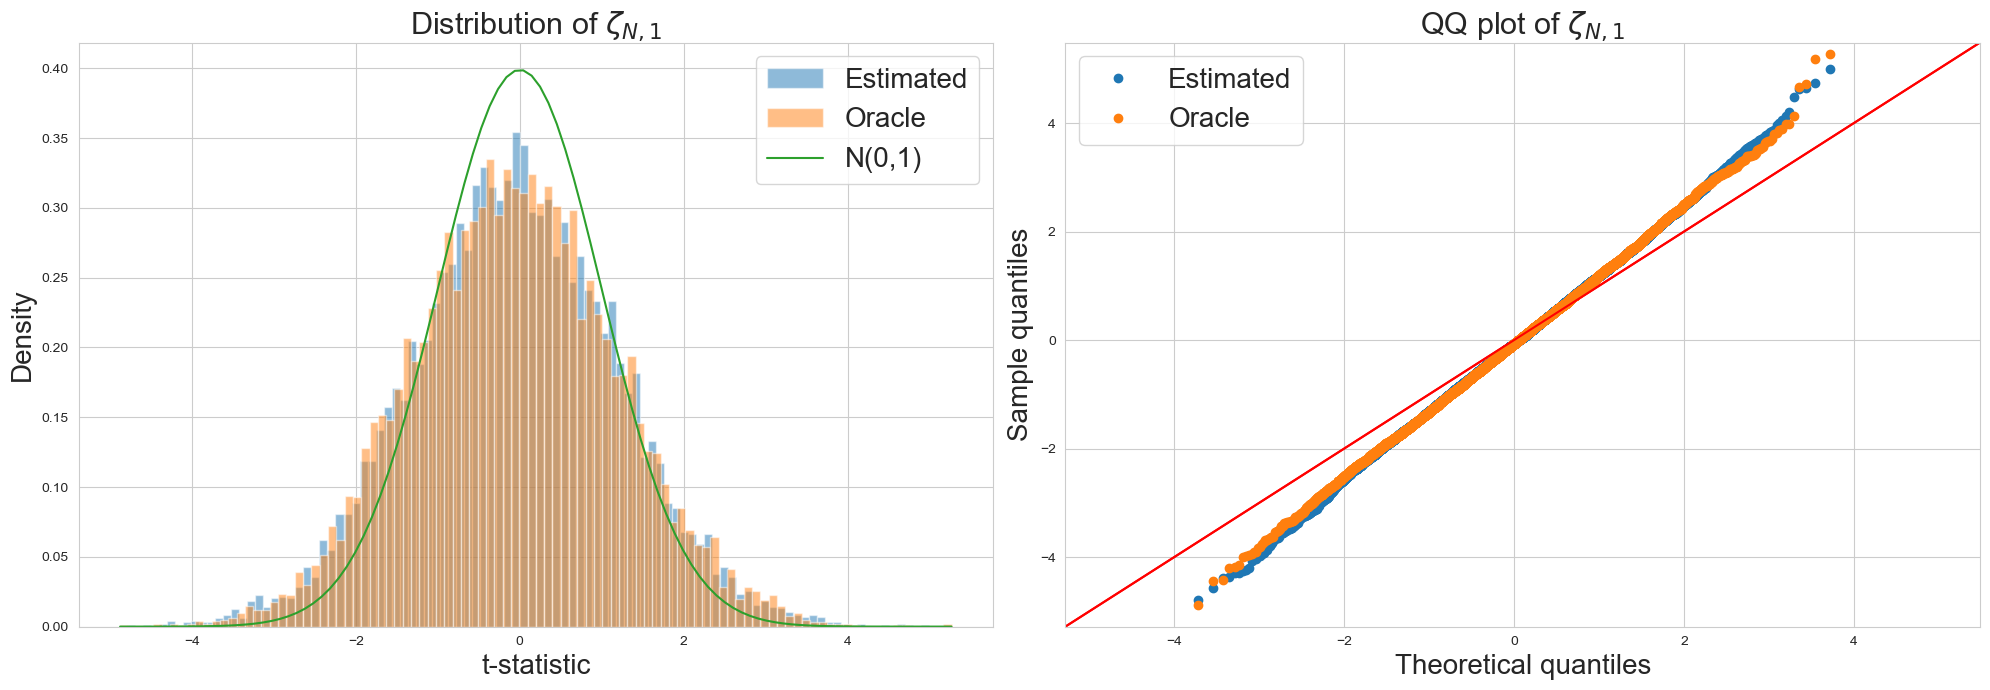

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(2 * 10, 7))

# plot distribution of t_stat_1
ax = axs[0]
all_t_stat_1_oracle = np.array([r.t_stat_1 for r in results_oracle])
all_t_stat_1_hat = np.array([r.t_stat_1 for r in results_hat])
ax.hist(all_t_stat_1_hat, bins=100, density=True, alpha=0.5, label="Estimated")
ax.hist(all_t_stat_1_oracle, bins=100, density=True, alpha=0.5, label="Oracle")
x_range = np.linspace(np.min(all_t_stat_1_oracle), np.max(all_t_stat_1_oracle), 100)
ax.plot(x_range, norm.pdf(x_range, 0, 1), label="N(0,1)")
ax.legend(fontsize=20)
ax.set_title(r"Distribution of $\zeta_{N, 1}$", fontsize=22)
ax.set_xlabel("t-statistic", fontsize=20)
ax.set_ylabel("Density", fontsize=20)

ax = axs[1]
qqplot(
    all_t_stat_1_hat,
    dist=norm,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:blue",
    markeredgecolor="tab:blue",
    label="Estimated",
)
qqplot(
    all_t_stat_1_oracle,
    dist=norm,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:orange",
    markeredgecolor="tab:orange",
    label="Oracle",
)
ax.set_title(r"QQ plot of $\zeta_{N, 1}$", fontsize=22)
ax.set_xlabel("Theoretical quantiles", fontsize=20)
ax.set_ylabel("Sample quantiles", fontsize=20)
ax.legend(fontsize=20)

plt.tight_layout()
plt.show()

fig.savefig(storage_path / "zeta-1-distribution.png")

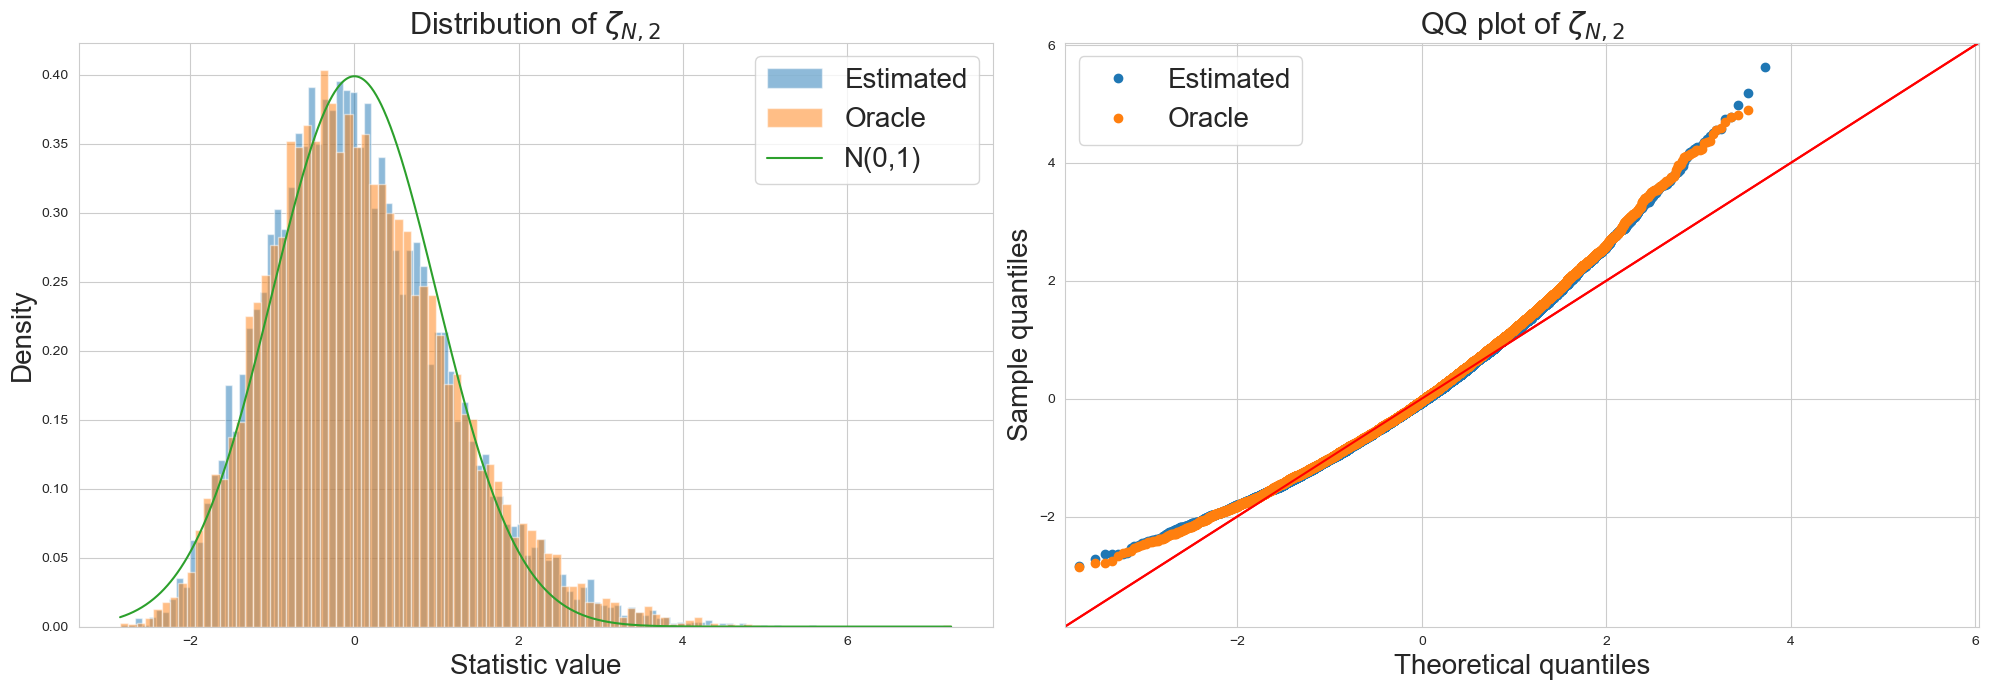

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(2 * 10, 7))

# Plot t_stat_2 values against N(0,1)
ax = axs[0]
n_freqs = len(results_oracle[0].t_stats_0)
all_t_stat_2_oracle = np.array([r.t_stat_2 for r in results_oracle])
all_t_stat_2_hat = np.array([r.t_stat_2 for r in results_hat])
ax.hist(all_t_stat_2_hat, bins=100, density=True, alpha=0.5, label="Estimated")
ax.hist(all_t_stat_2_oracle, bins=100, density=True, alpha=0.5, label="Oracle")
x_range = np.linspace(
    np.min([all_t_stat_2_oracle, all_t_stat_2_hat]),
    np.max([all_t_stat_2_oracle, all_t_stat_2_hat]),
    1000,
)
ax.plot(x_range, norm.pdf(x_range, 0, 1), label="N(0,1)")

ax.set_title(r"Distribution of $\zeta_{N, 2}$", fontsize=22)
ax.set_xlabel("Statistic value", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.legend(fontsize=20)

# in another graph, show the qqplot of t_stat_2
ax = axs[1]
qqplot(
    all_t_stat_2_hat,
    dist=norm,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:blue",
    markeredgecolor="tab:blue",
    label="Estimated",
)
qqplot(
    all_t_stat_2_oracle,
    dist=norm,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:orange",
    markeredgecolor="tab:orange",
    label="Oracle",
)
ax.legend(fontsize=20)
ax.set_title(r"QQ plot of $\zeta_{N, 2}$", fontsize=22)
ax.set_xlabel("Theoretical quantiles", fontsize=20)
ax.set_ylabel("Sample quantiles", fontsize=20)

plt.tight_layout()
plt.show()

fig.savefig(storage_path / "zeta-2-distribution-against-normal.png")

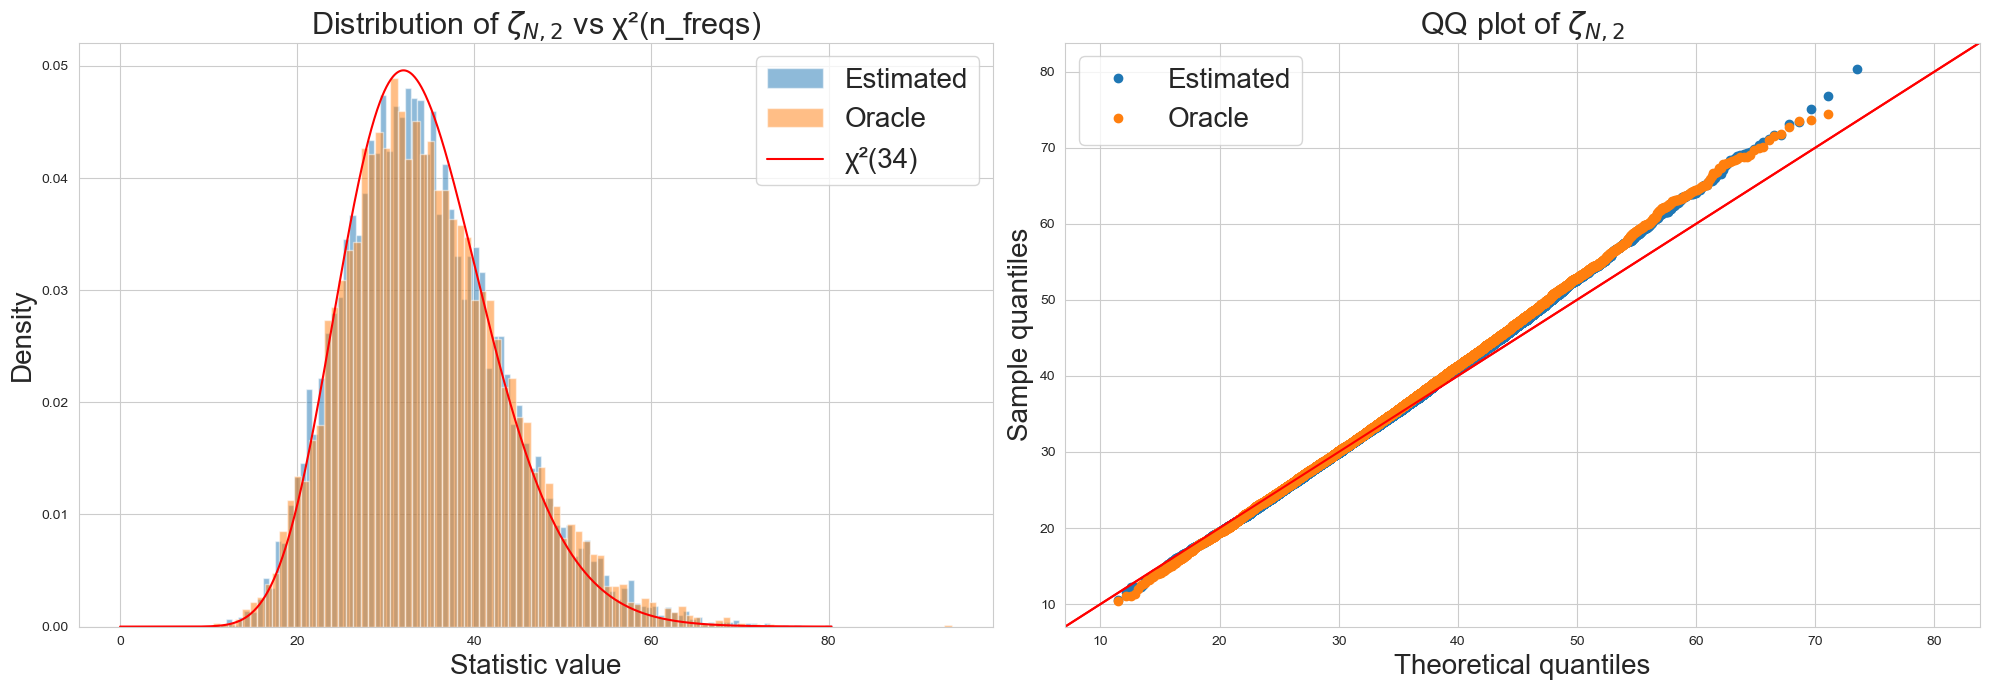

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(2 * 10, 7))

# Plot t_stat_3 values against chi2
ax = axs[0]
n_freqs = len(results_oracle[0].t_stats_0)
all_t_stat_3_oracle = np.array([r.t_stat_3 for r in results_oracle])
all_t_stat_3_hat = np.array([r.t_stat_3 for r in results_hat])
ax.hist(all_t_stat_3_hat, bins=100, density=True, alpha=0.5, label="Estimated")
ax.hist(all_t_stat_3_oracle, bins=100, density=True, alpha=0.5, label="Oracle")
x_range = np.linspace(0, np.max(all_t_stat_3_hat), 1000)
ax.plot(x_range, chi2.pdf(x_range, df=n_freqs), label=f"χ²({n_freqs})", color="red")

ax.set_title(r"Distribution of $\zeta_{N,2}$ vs χ²(n_freqs)", fontsize=22)
ax.set_xlabel("Statistic value", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.legend(fontsize=20)

# in another graph, show the qqplot of t_stat_3
ax = axs[1]
qqplot(
    all_t_stat_3_hat,
    dist=chi2,
    distargs=(n_freqs,),
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:blue",
    markeredgecolor="tab:blue",
    label="Estimated",
)
qqplot(
    all_t_stat_3_oracle,
    dist=chi2,
    distargs=(n_freqs,),
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:orange",
    markeredgecolor="tab:orange",
    label="Oracle",
)
ax.legend(fontsize=20)
ax.set_title(r"QQ plot of $\zeta_{N, 2}$", fontsize=22)
ax.set_xlabel("Theoretical quantiles", fontsize=20)
ax.set_ylabel("Sample quantiles", fontsize=20)

plt.tight_layout()
plt.show()

fig.savefig(storage_path / "zeta-2-distribution-against-chi2.png")

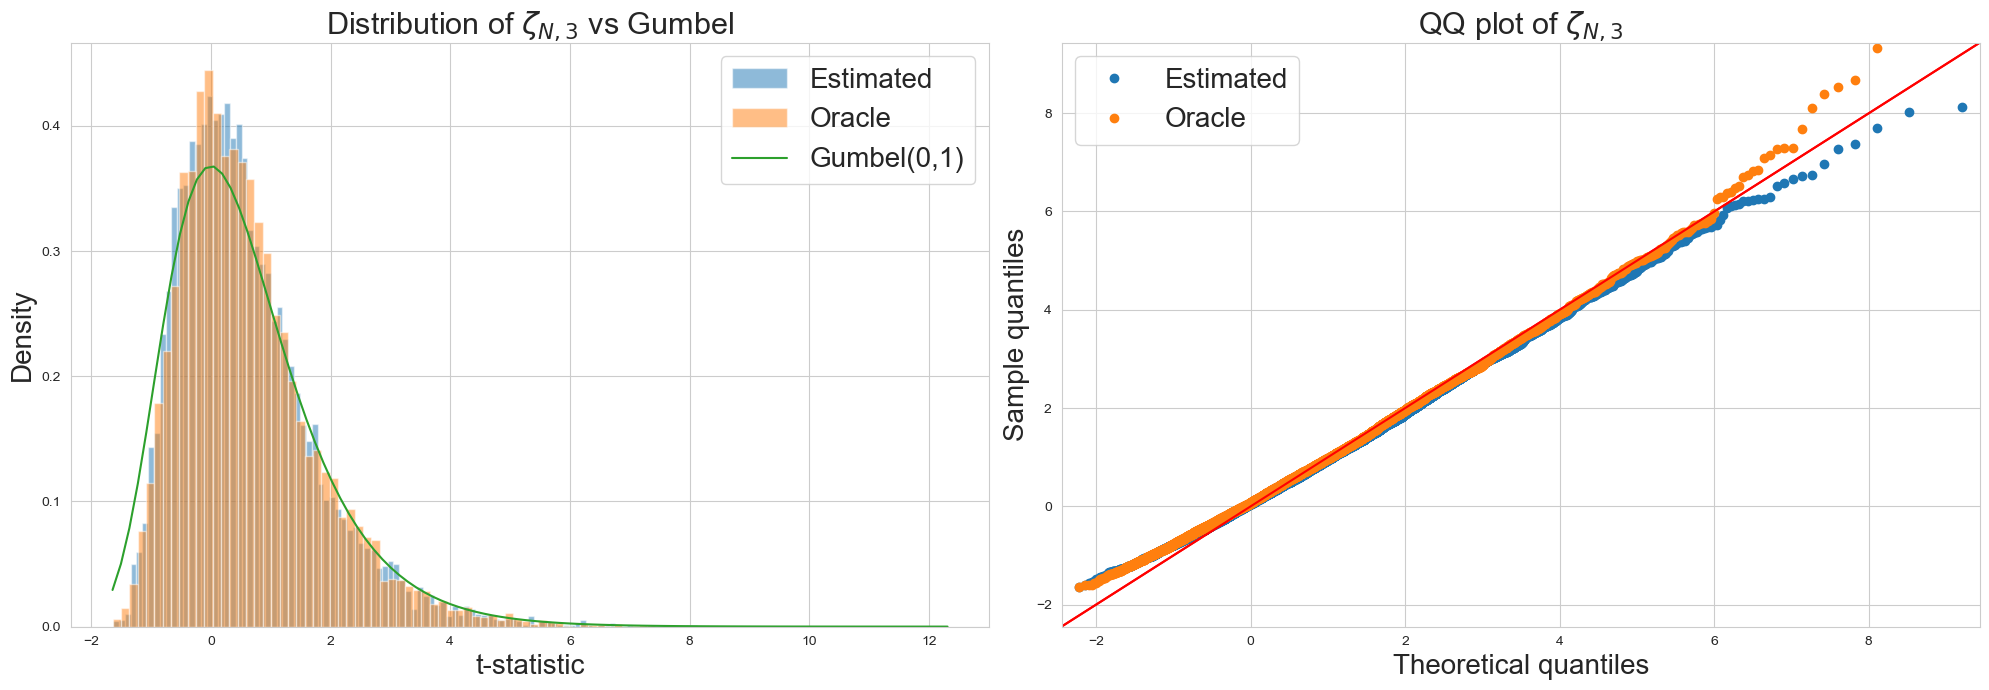

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(2 * 10, 7))

# plot t_stat_4 against Gumbel
ax = axs[0]
all_t_stat_4_oracle = np.array([r.t_stat_4 for r in results_oracle])
all_t_stat_4_hat = np.array([r.t_stat_4 for r in results_hat])
ax.hist(all_t_stat_4_hat, bins=100, density=True, alpha=0.5, label="Estimated")
ax.hist(all_t_stat_4_oracle, bins=100, density=True, alpha=0.5, label="Oracle")
x_range = np.linspace(
    np.min([all_t_stat_4_oracle, all_t_stat_4_hat]),
    np.max([all_t_stat_4_oracle, all_t_stat_4_hat]),
    100,
)
ax.plot(x_range, gumbel_r.pdf(x_range), label="Gumbel(0,1)")
ax.legend(fontsize=20)
ax.set_title(r"Distribution of $\zeta_{N,3}$ vs Gumbel", fontsize=22)
ax.set_xlabel("t-statistic", fontsize=20)
ax.set_ylabel("Density", fontsize=20)

ax = axs[1]
qqplot(
    all_t_stat_4_hat,
    dist=gumbel_r,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:blue",
    markeredgecolor="tab:blue",
    label="Estimated",
)
qqplot(
    all_t_stat_4_oracle,
    dist=gumbel_r,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:orange",
    markeredgecolor="tab:orange",
    label="Oracle",
)
ax.legend(fontsize=20)
ax.set_title(r"QQ plot of $\zeta_{N,3}$", fontsize=22)
ax.set_xlabel("Theoretical quantiles", fontsize=20)
ax.set_ylabel("Sample quantiles", fontsize=20)

plt.tight_layout()
plt.show()

fig.savefig(storage_path / "zeta-4-distribution-against-gumbel.png")

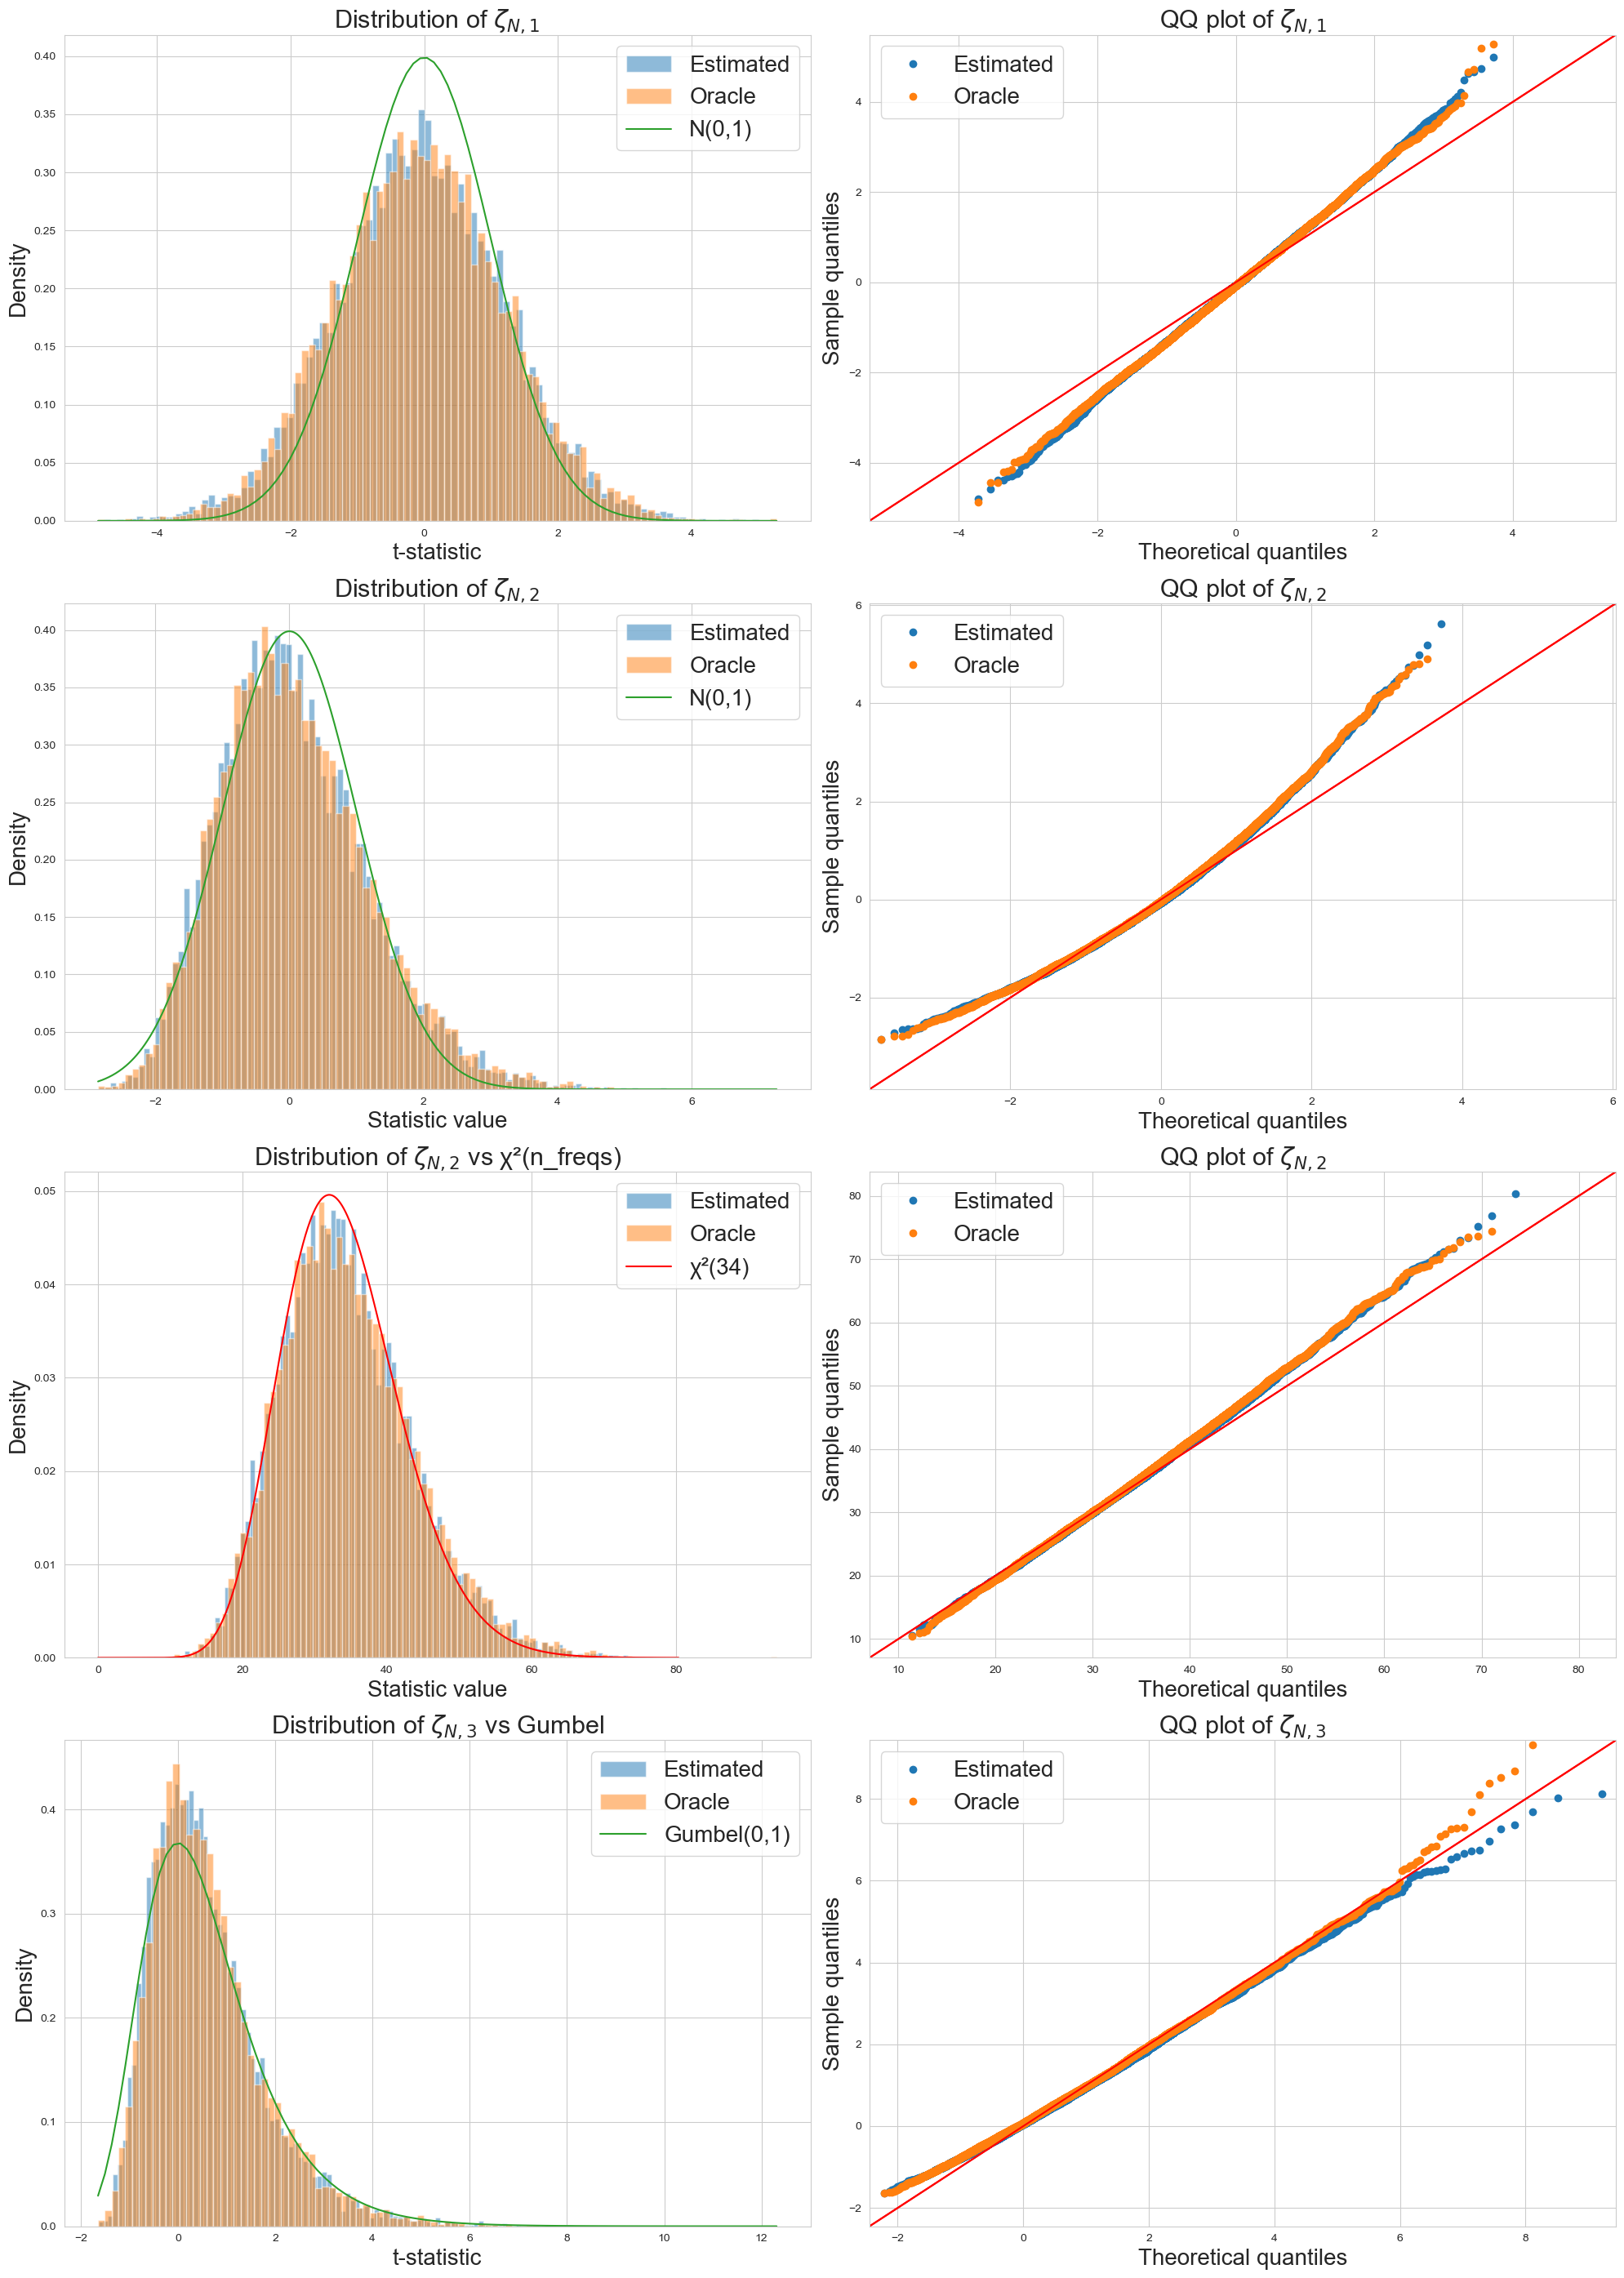

In [12]:
fig, axs = plt.subplots(4, 2, figsize=(2 * 10, 7 * 4))

# plot distribution of t_stat_1
ax = axs[0, 0]
all_t_stat_1_oracle = np.array([r.t_stat_1 for r in results_oracle])
all_t_stat_1_hat = np.array([r.t_stat_1 for r in results_hat])
ax.hist(all_t_stat_1_hat, bins=100, density=True, alpha=0.5, label="Estimated")
ax.hist(all_t_stat_1_oracle, bins=100, density=True, alpha=0.5, label="Oracle")
x_range = np.linspace(np.min(all_t_stat_1_oracle), np.max(all_t_stat_1_oracle), 100)
ax.plot(x_range, norm.pdf(x_range, 0, 1), label="N(0,1)")
ax.legend(fontsize=20)
ax.set_title(r"Distribution of $\zeta_{N, 1}$", fontsize=22)
ax.set_xlabel("t-statistic", fontsize=20)
ax.set_ylabel("Density", fontsize=20)

ax = axs[0, 1]
qqplot(
    all_t_stat_1_hat,
    dist=norm,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:blue",
    markeredgecolor="tab:blue",
    label="Estimated",
)
qqplot(
    all_t_stat_1_oracle,
    dist=norm,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:orange",
    markeredgecolor="tab:orange",
    label="Oracle",
)
ax.set_title(r"QQ plot of $\zeta_{N, 1}$", fontsize=22)
ax.set_xlabel("Theoretical quantiles", fontsize=20)
ax.set_ylabel("Sample quantiles", fontsize=20)
ax.legend(fontsize=20)


#######

# Plot t_stat_2 values against N(0,1)
ax = axs[1, 0]
n_freqs = len(results_oracle[0].t_stats_0)
all_t_stat_2_oracle = np.array([r.t_stat_2 for r in results_oracle])
all_t_stat_2_hat = np.array([r.t_stat_2 for r in results_hat])
ax.hist(all_t_stat_2_hat, bins=100, density=True, alpha=0.5, label="Estimated")
ax.hist(all_t_stat_2_oracle, bins=100, density=True, alpha=0.5, label="Oracle")
x_range = np.linspace(
    np.min([all_t_stat_2_oracle, all_t_stat_2_hat]),
    np.max([all_t_stat_2_oracle, all_t_stat_2_hat]),
    1000,
)
ax.plot(x_range, norm.pdf(x_range, 0, 1), label="N(0,1)")

ax.set_title(r"Distribution of $\zeta_{N, 2}$", fontsize=22)
ax.set_xlabel("Statistic value", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.legend(fontsize=20)

# in another graph, show the qqplot of t_stat_2
ax = axs[1, 1]
qqplot(
    all_t_stat_2_hat,
    dist=norm,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:blue",
    markeredgecolor="tab:blue",
    label="Estimated",
)
qqplot(
    all_t_stat_2_oracle,
    dist=norm,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:orange",
    markeredgecolor="tab:orange",
    label="Oracle",
)
ax.legend(fontsize=20)
ax.set_title(r"QQ plot of $\zeta_{N, 2}$", fontsize=22)
ax.set_xlabel("Theoretical quantiles", fontsize=20)
ax.set_ylabel("Sample quantiles", fontsize=20)


##############

# Plot t_stat_3 values against chi2
ax = axs[2, 0]
n_freqs = len(results_oracle[0].t_stats_0)
all_t_stat_3_oracle = np.array([r.t_stat_3 for r in results_oracle])
all_t_stat_3_hat = np.array([r.t_stat_3 for r in results_hat])
ax.hist(all_t_stat_3_hat, bins=100, density=True, alpha=0.5, label="Estimated")
ax.hist(all_t_stat_3_oracle, bins=100, density=True, alpha=0.5, label="Oracle")
x_range = np.linspace(0, np.max(all_t_stat_3_hat), 1000)
ax.plot(x_range, chi2.pdf(x_range, df=n_freqs), label=f"χ²({n_freqs})", color="red")

ax.set_title(r"Distribution of $\zeta_{N,2}$ vs χ²(n_freqs)", fontsize=22)
ax.set_xlabel("Statistic value", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.legend(fontsize=20)

# in another graph, show the qqplot of t_stat_3
ax = axs[2, 1]
qqplot(
    all_t_stat_3_hat,
    dist=chi2,
    distargs=(n_freqs,),
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:blue",
    markeredgecolor="tab:blue",
    label="Estimated",
)
qqplot(
    all_t_stat_3_oracle,
    dist=chi2,
    distargs=(n_freqs,),
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:orange",
    markeredgecolor="tab:orange",
    label="Oracle",
)
ax.legend(fontsize=20)
ax.set_title(r"QQ plot of $\zeta_{N, 2}$", fontsize=22)
ax.set_xlabel("Theoretical quantiles", fontsize=20)
ax.set_ylabel("Sample quantiles", fontsize=20)


#################


# plot t_stat_4 against Gumbel
ax = axs[3, 0]
all_t_stat_4_oracle = np.array([r.t_stat_4 for r in results_oracle])
all_t_stat_4_hat = np.array([r.t_stat_4 for r in results_hat])
ax.hist(all_t_stat_4_hat, bins=100, density=True, alpha=0.5, label="Estimated")
ax.hist(all_t_stat_4_oracle, bins=100, density=True, alpha=0.5, label="Oracle")
x_range = np.linspace(
    np.min([all_t_stat_4_oracle, all_t_stat_4_hat]),
    np.max([all_t_stat_4_oracle, all_t_stat_4_hat]),
    100,
)
ax.plot(x_range, gumbel_r.pdf(x_range), label="Gumbel(0,1)")
ax.legend(fontsize=20)
ax.set_title(r"Distribution of $\zeta_{N,3}$ vs Gumbel", fontsize=22)
ax.set_xlabel("t-statistic", fontsize=20)
ax.set_ylabel("Density", fontsize=20)

ax = axs[3, 1]
qqplot(
    all_t_stat_4_hat,
    dist=gumbel_r,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:blue",
    markeredgecolor="tab:blue",
    label="Estimated",
)
qqplot(
    all_t_stat_4_oracle,
    dist=gumbel_r,
    line="45",
    ax=ax,
    marker="o",
    markerfacecolor="tab:orange",
    markeredgecolor="tab:orange",
    label="Oracle",
)
ax.legend(fontsize=20)
ax.set_title(r"QQ plot of $\zeta_{N,3}$", fontsize=22)
ax.set_xlabel("Theoretical quantiles", fontsize=20)
ax.set_ylabel("Sample quantiles", fontsize=20)


###########

plt.tight_layout()
plt.show()

fig.savefig(storage_path / "zeta-all-distribution.png")